# Looked After Children (LAC) LSOA Analysis


# Importing Necessary Libraries

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
import seaborn as sns
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy import stats
import statsmodels.api as sm

import sys
sys.path.append('../code')
from data_cleaning import gender_mapping

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
color='#702A7D'

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

# Define Query to Get Data

In [3]:
query = """
WITH lac_WithAddress AS (
  SELECT
    lac.person_id,
    lac.StartDate,
    lac.EndDate,
    lac.EthnicOrigin,
    DATE(p.birth_datetime) AS DateOfBirth,
    p.gender_source_value AS Gender,
    a.SOA AS LSOA,
    /* For each lac row, rank the joined address rows 
       (if any) by DateEvent (converted to DATE) descending */
       
    ROW_NUMBER() OVER (
      PARTITION BY lac.person_id, lac.StartDate
      ORDER BY DATE(a.DateEvent) DESC
    ) AS rn
  FROM
    `yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CiC` lac
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.tbl_AddressHistory_New` a
      ON lac.person_id = a.person_id
      AND DATE(a.DateEvent) <= lac.StartDate
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.person` p
      ON lac.person_id = p.person_id
)
SELECT 
  person_id,
  Gender,      
  StartDate,
  EndDate,
  EthnicOrigin,
  DateOfBirth,
  LSOA
FROM
  lac_WithAddress
WHERE 
  rn = 1;
"""

# Load Query into Pandas Dataframe

In [4]:
lac = pandas_gbq.read_gbq(query)

Downloading: 100%|██████████|


In [5]:
# Information about the columns
lac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   person_id     1917 non-null   object
 1   Gender        1910 non-null   object
 2   StartDate     1917 non-null   dbdate
 3   EndDate       961 non-null    dbdate
 4   EthnicOrigin  1917 non-null   object
 5   DateOfBirth   1911 non-null   dbdate
 6   LSOA          1333 non-null   object
dtypes: dbdate(3), object(4)
memory usage: 105.0+ KB


In [6]:
# Count number of missing values
missing_values = lac.isnull().sum()
total_values = lac.shape[0]
percentage_missing = round(missing_values/total_values*100, 2)
percentage_missing

person_id        0.00
Gender           0.37
StartDate        0.00
EndDate         49.87
EthnicOrigin     0.00
DateOfBirth      0.31
LSOA            30.46
dtype: float64

In [7]:
# Strip whitespace from all string/object columns
lac = lac.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [8]:
# Clean gender column
gender_mapping(lac, 'Gender')

array(['Male', 'Female', nan, None], dtype=object)

# Load Bradford Children Population Data 0-17 years, 2021.
source: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimates

In [9]:
# Import population data
population_data_file_path = '../data/Bradford_Children_population_0-17_2021.csv'
population_data = pd.read_csv(population_data_file_path)
population_data.columns

Index(['LAD 2021 Code', 'LAD 2021 Name', 'LSOA 2021 Code', 'LSOA 2021 Name',
       'TotalPop', 'FemalePop', 'MalePop'],
      dtype='object')

# Load Bradford Boundary Data
source: https://borders.ukdataservice.ac.uk/

In [10]:
# Import boundary data
boundary_data_filepath = "../data/BradfordBoundaryData/england_lsoa_2021.shp"
bradord_boundary_data = gpd.read_file(boundary_data_filepath)

# Print data type and crs
print(type(bradord_boundary_data))
print(bradord_boundary_data.crs)
print(bradord_boundary_data.columns)

<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:27700
Index(['lsoa21cd', 'lsoa21nm', 'label', 'name', 'geometry'], dtype='object')


# Load Index of Multiple Deprivation (IMD) Data
source: https://data.cdrc.ac.uk/dataset/index-multiple-deprivation-imd

In [11]:
# Import IMD data
imd_filepath = "../data/English IMD 2019/IMD_2019.shp"
imd = gpd.read_file(imd_filepath)

In [12]:
# Display the columns in the IMD data
imd.columns

Index(['lsoa11cd', 'lsoa11nm', 'lsoa11nmw', 'st_areasha', 'st_lengths',
       'IMD_Rank', 'IMD_Decile', 'LSOA01NM', 'LADcd', 'LADnm', 'IMDScore',
       'IMDRank0', 'IMDDec0', 'IncScore', 'IncRank', 'IncDec', 'EmpScore',
       'EmpRank', 'EmpDec', 'EduScore', 'EduRank', 'EduDec', 'HDDScore',
       'HDDRank', 'HDDDec', 'CriScore', 'CriRank', 'CriDec', 'BHSScore',
       'BHSRank', 'BHSDec', 'EnvScore', 'EnvRank', 'EnvDec', 'IDCScore',
       'IDCRank', 'IDCDec', 'IDOScore', 'IDORank', 'IDODec', 'CYPScore',
       'CYPRank', 'CYPDec', 'ASScore', 'ASRank', 'ASDec', 'GBScore', 'GBRank',
       'GBDec', 'WBScore', 'WBRank', 'WBDec', 'IndScore', 'IndRank', 'IndDec',
       'OutScore', 'OutRank', 'OutDec', 'TotPop', 'DepChi', 'Pop16_59',
       'Pop60+', 'WorkPop', 'geometry'],
      dtype='object')

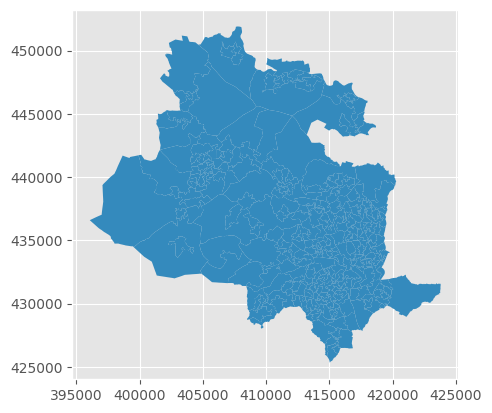

In [13]:
# Display the map
bradord_boundary_data.plot();

In [14]:
# Drop rows where LSOA is missing
lac = lac.dropna(subset=['LSOA'])
lac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1333 entries, 0 to 1915
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   person_id     1333 non-null   object
 1   Gender        1332 non-null   object
 2   StartDate     1333 non-null   dbdate
 3   EndDate       658 non-null    dbdate
 4   EthnicOrigin  1333 non-null   object
 5   DateOfBirth   1333 non-null   dbdate
 6   LSOA          1333 non-null   object
dtypes: dbdate(3), object(4)
memory usage: 83.3+ KB


In [15]:
# Convert dates data types 
dates_columns = ['StartDate', 'EndDate', 'DateOfBirth']
lac[dates_columns] = lac[dates_columns].apply(pd.to_datetime)

In [16]:
# Creating New Columns

# Number of Days in Intervention
lac['num_of_days_in_intervention'] = (lac['EndDate'] - lac['StartDate']).dt.days


# Calculate age at entry (completed years)
lac['age_at_entry'] = lac.apply(
    lambda row: relativedelta(row['StartDate'], row['DateOfBirth']).years,
    axis=1
).astype('int')

# Keep rows where age is between 0-17
lac = lac.loc[lac['age_at_entry'] < 18]

# Age Binning
bins = [0, 1, 4, 9, 15, 16]
labels = ['Under 1', '1-4', '5-9', '10-15', '16+']
lac['entry_agegroup'] = pd.cut(lac['age_at_entry'], 
                             bins=bins, 
                             labels=labels,
                             right=True)

In [17]:
# Example of unique LSOA prefixes
lac['lsoa_prefix'] = lac['LSOA'].str[:3]
print(lac['lsoa_prefix'].unique())

['E01' '' 'W01' 'S01']


In [18]:
# Filter lac to keep only English LSOAs (starting with 'E01') and remove empty strings
lac_english_lsoa = lac[lac['LSOA'].str.startswith('E01', na=False)].copy()

print(f"Number of rows in lac before filtering: {len(lac)}")
print(f"Number of rows in lac_english_lsoa after filtering: {len(lac_english_lsoa)}")

Number of rows in lac before filtering: 1331
Number of rows in lac_english_lsoa after filtering: 1159


In [19]:
lac_english_lsoa['LSOA'].nunique()

398

# Merge intervention and boundary data

In [20]:
# 1. Check for missing matches before merging
print("Bradford boundary unique LSOAs:", len(bradord_boundary_data['lsoa21cd'].unique()))
print("lac English unique LSOAs:", len(lac_english_lsoa['LSOA'].unique()))
print("Common LSOAs:", len(set(bradord_boundary_data['lsoa21cd']).intersection(set(lac_english_lsoa['LSOA']))))

# 2. Use left merge to preserve geometry
merged_data = bradord_boundary_data.merge(
    lac_english_lsoa,
    left_on='lsoa21cd',
    right_on='LSOA',
    how='left',
)

# 3. Verify geometry column is preserved
print("Geometry column present:", 'geometry' in merged_data.columns)
print(merged_data.crs)

Bradford boundary unique LSOAs: 312
lac English unique LSOAs: 398
Common LSOAs: 227
Geometry column present: True
EPSG:27700


<Axes: >

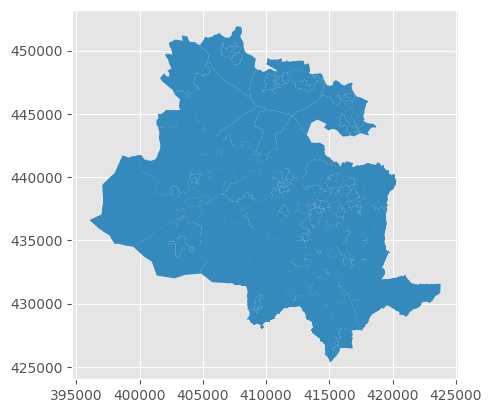

In [21]:
# Confirm the map plot
merged_data.plot()

In [22]:
merged_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   lsoa21cd                     991 non-null    object        
 1   lsoa21nm                     991 non-null    object        
 2   label                        991 non-null    object        
 3   name                         991 non-null    object        
 4   geometry                     991 non-null    geometry      
 5   person_id                    906 non-null    object        
 6   Gender                       905 non-null    object        
 7   StartDate                    906 non-null    datetime64[ns]
 8   EndDate                      473 non-null    datetime64[ns]
 9   EthnicOrigin                 906 non-null    object        
 10  DateOfBirth                  906 non-null    datetime64[ns]
 11  LSOA                         906 non-

In [23]:
# Drop unwanted columns due to merge
columns_to_drop = ['lsoa21nm', 'label', 'LSOA']
merged_data.drop(columns=columns_to_drop, inplace=True)

#### Number of LAC per LSOA - Is there a significant variation in number of LAC across LSOAs

In [24]:
# Group by LSOA and count the number of children
children_per_lsoa = merged_data.groupby('lsoa21cd', as_index=False).agg(
    children_count=('lsoa21cd', 'size'),
    geometry=('geometry', 'first')
).pipe(gpd.GeoDataFrame)

# Merge with IMD Data
columns_to_include_from_imd = [
    'lsoa11cd', 'IMD_Decile', 'IMDScore',
    'IDCDec', 'CYPDec', 'IncDec', 'EmpDec',
    'EduDec', 'CriDec', 'BHSDec', 'EnvDec',
    'HDDDec', 'DepChi'
]
children_per_lsoa = children_per_lsoa.merge(
    imd[columns_to_include_from_imd],
    left_on ='lsoa21cd',
    right_on='lsoa11cd',
    how='left'
).drop(columns='lsoa11cd')

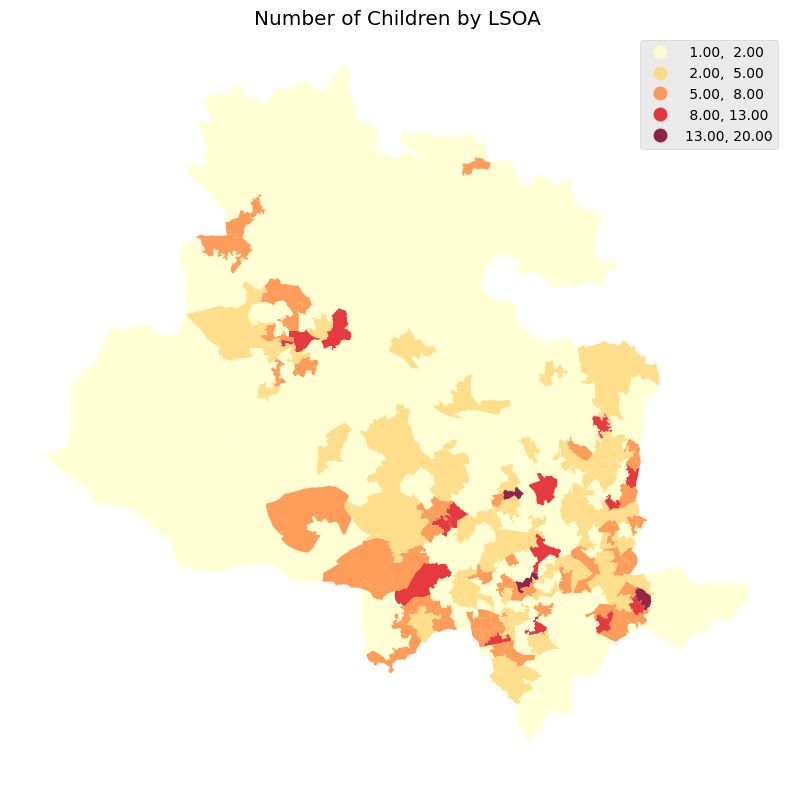

In [25]:
# Step 3: Plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) 

children_per_lsoa.plot(
    ax=ax,                  
    column='children_count',
    scheme='FisherJenks',     
    cmap='YlOrRd',
    alpha=0.85,
    legend=True,            
)

# Remove axis for better visualization
ax.set_axis_off()
# Add a title
ax.set_title("Number of Children by LSOA")
# Show the plot
plt.show()

### LAC Population Rate  by LSOA - Looking at rate helps us balance uneven population across LSOAs

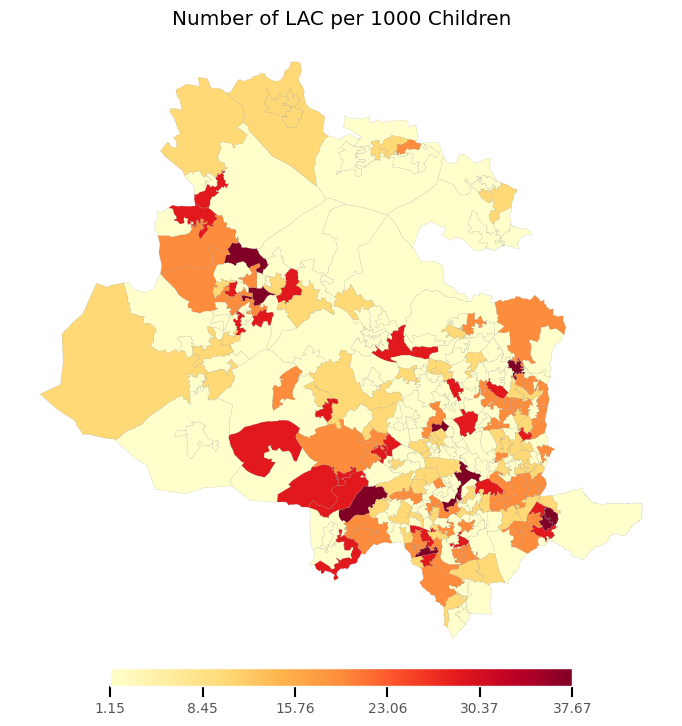

In [26]:
# Merge with population data
children_population = children_per_lsoa.merge(
    population_data[['LSOA 2021 Code', 'TotalPop']],
    left_on='lsoa21cd',
    right_on='LSOA 2021 Code',
    how='left'
).drop(columns='LSOA 2021 Code')

# Calculate children proportion
children_population['intervention_children_per_1000_children'] = (
    children_population['children_count'] /
    children_population['TotalPop']) * 1000

# Create figure and plot
fig, ax = plt.subplots(figsize=(8, 8))
children_population.plot(
    ax=ax,
    column='intervention_children_per_1000_children',
    scheme='NaturalBreaks',
    cmap='YlOrRd',
    edgecolor='grey',
    linewidth=0.1,
    legend=False
)

# Create colorbar
vmin = children_population['intervention_children_per_1000_children'].min()
vmax = children_population['intervention_children_per_1000_children'].max()
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

# Add colorbar with customized ticks
cbar = fig.colorbar(sm, ax=ax,
                   orientation='horizontal',
                   pad=0.0005,
                   shrink=0.6,
                   aspect=25)
ticks = np.linspace(vmin, vmax, 6)
cbar.set_ticks(np.linspace(vmin, vmax, 6))
cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks])
cbar.ax.tick_params(size=8, width=1.5, direction='out', color='black')

# Finalize plot
ax.set_axis_off()
ax.set_title('Number of LAC per 1000 Children')
plt.tight_layout()
plt.savefig(f'../figs/LAC_intervention_rate_map.png', dpi=300)
plt.show()

In [27]:
intervention_rate = children_population[['lsoa21cd', 'children_count', 'TotalPop','intervention_children_per_1000_children']]
intervention_rate = intervention_rate.rename(columns={
    'TotalPop': 'children_population',
    'intervention_children_per_1000_children': 'lac_children_per_1000_children'
})
intervention_rate_df = intervention_rate.sort_values(by='lac_children_per_1000_children', ascending=False)
intervention_rate_df

,lsoa21cd,children_count,children_population,lac_children_per_1000_children
260,E01010834,11,292,37.671233
275,E01010851,11,301,36.544850
103,E01010673,20,579,34.542314
66,E01010634,9,304,29.605263
164,E01010735,19,647,29.366306
...,...,...,...,...
309,E01033899,1,781,1.280410
238,E01010811,1,794,1.259446
263,E01010838,1,795,1.257862
303,E01033693,1,827,1.209190


## What percentage of LSOAs accounts for what percentage of Children in LAC?

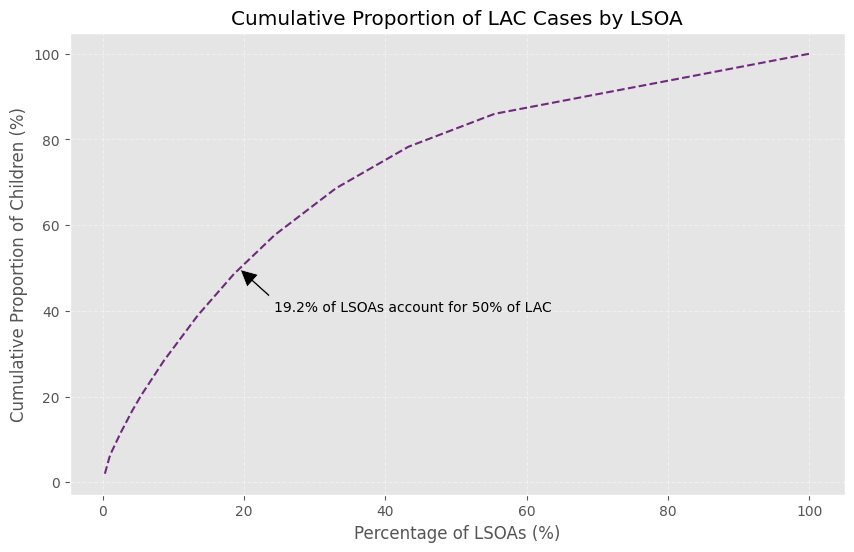

In [28]:
# Number of children
total_children = children_per_lsoa['children_count'].sum()

# Sort by children_count (descending):
children_per_lsoa_sorted = children_per_lsoa.sort_values(by='children_count', ascending=False)

# Calculate the cumulative sum and proportion:
children_per_lsoa_sorted['cumulative_children'] = children_per_lsoa_sorted['children_count'].cumsum()
children_per_lsoa_sorted['cumulative_percent'] = (
    100.0 * children_per_lsoa_sorted['cumulative_children'] / total_children
    
    
)
# Number of LSOAs
num_lsoas = len(children_per_lsoa_sorted)
x_percent = [(i + 1) / num_lsoas * 100 for i in range(num_lsoas)]

# Find the percentage of LSOAs that account for 50% of children
lsoas_for_50_percent = len(children_per_lsoa_sorted[children_per_lsoa_sorted['cumulative_percent'] <= 50])
percent_lsoas_for_50 = (lsoas_for_50_percent / num_lsoas) * 100

# Create an x-axis representing the percentage of LSOAs.
num_lsoas = len(children_per_lsoa_sorted)
x_percent = [(i + 1) / num_lsoas * 100 for i in range(num_lsoas)]

# Plot cumulative proportion vs. number of LSOAs:
plt.figure(figsize=(10, 6))
plt.plot(
    x_percent,
    children_per_lsoa_sorted['cumulative_percent'],
    linestyle='--',
    color=color
)

# Add annotation
plt.annotate(f'{percent_lsoas_for_50:.1f}% of LSOAs account for 50% of LAC',
             xy=(percent_lsoas_for_50, 50),
             xytext=(percent_lsoas_for_50 + 5, 40),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

plt.title('Cumulative Proportion of LAC Cases by LSOA')
plt.xlabel('Percentage of LSOAs (%)')
plt.ylabel('Cumulative Proportion of Children (%)')
plt.grid(True, linestyle='--', alpha=.4)
plt.savefig("../figs/children_proportion_per_LSOAproportion.png", dpi=300)
plt.show()

#### LAC Rate vs. IMD Decile by LSOA -  Is there a relationship btw rate of LAC and the IMD rank of the LSOA = are more LAC in deprived areas?

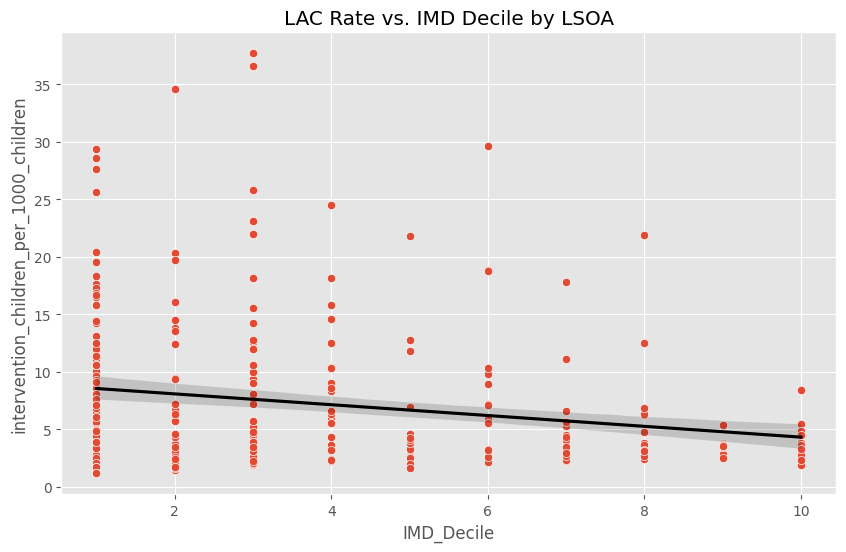

Pearson Correlation: -0.207 (p-value: 2.632e-04)
Spearman Correlation: -0.183 (p-value: 1.288e-03)

Linear Regression Results:
Slope: -0.470214
Intercept: 9.006
R-squared: 0.043
P-value: 2.632e-04


In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=children_population,
    x='IMD_Decile',
    y='intervention_children_per_1000_children',
)

# Add a trendline
sns.regplot(
    data=children_population,
    x='IMD_Decile',
    y='intervention_children_per_1000_children',
    scatter=False,
    color='black'
)
plt.title('LAC Rate vs. IMD Decile by LSOA')
plt.savefig("../figs/LAC_Rate_vs.IMD_Decile.png", dpi=300)
plt.show()


# Determine the relationship between IMD Decile and Proportion of LAC 


# Drop rows with NaN
valid = (
    children_population['IMD_Decile'].notna() &
    children_population['intervention_children_per_1000_children'].notna()
)
clean_data = children_population[valid]

# Pearson Correlation
correlation, p_value = stats.pearsonr(clean_data['IMD_Decile'], clean_data['intervention_children_per_1000_children'])

# Spearman Correlation
spearman_corr, spearman_p = stats.spearmanr(clean_data['IMD_Decile'], clean_data['intervention_children_per_1000_children'])

# Linear Regression
slope, intercept, r_value, p_value_reg, std_err = stats.linregress(clean_data['IMD_Decile'], clean_data['intervention_children_per_1000_children'])

# Print results
print(f"Pearson Correlation: {correlation:.3f} (p-value: {p_value:.3e})")
print(f"Spearman Correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3e})")
print("\nLinear Regression Results:")
print(f"Slope: {slope:.6f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value_reg:.3e}")

In [30]:
most_deprived = children_population.loc[children_population['IMD_Decile'] == 1]
less_deprived = children_population.loc[children_population['IMD_Decile'] == 10]

children_in_deprived_areas = len(most_deprived)
children_in_less_deprived_areas = len(less_deprived)

print(f"Children in the most deprived area: {children_in_deprived_areas}")
print(f"Children in the less deprived area: {children_in_less_deprived_areas}\n")

children_in_deprived_areas = len(most_deprived)
children_in_less_deprived_areas = len(less_deprived)

if children_in_less_deprived_areas > 0:
    # Calculate the ratio: how many children in the most deprived area per one child in the less deprived area.
    ratio = children_in_deprived_areas / children_in_less_deprived_areas
    # Calculate what percentage the less deprived count is of the most deprived count.
    percentage = (children_in_less_deprived_areas / children_in_deprived_areas) * 100

    print(f"For every 1 child in the less deprived area, there are approximately {ratio:.1f} children in the most deprived area.")
    print(f"In percentage terms, children in the less deprived area represent about {percentage:.1f}% of those in the most deprived area.")
else:
    print("There are no children in the less deprived area to compare.")

Children in the most deprived area: 104
Children in the less deprived area: 16

For every 1 child in the less deprived area, there are approximately 6.5 children in the most deprived area.
In percentage terms, children in the less deprived area represent about 15.4% of those in the most deprived area.


### LAC Rate and IDCScore -  child-specific deprivation measure

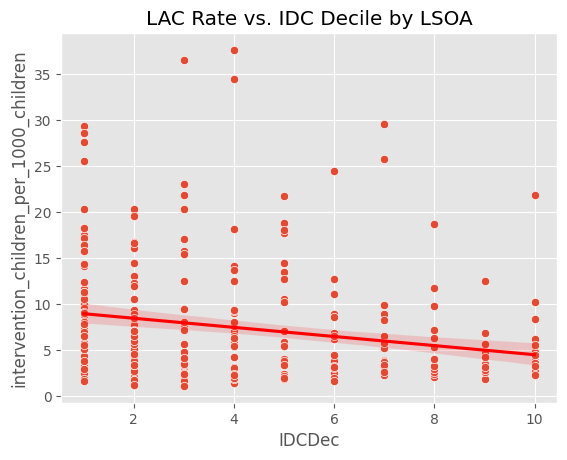

Pearson Correlation: -0.223 (p-value: 8.122e-05)
Spearman Correlation: -0.241 (p-value: 1.902e-05)

Linear Regression Results:
Slope: -0.495348
Intercept: 9.492
R-squared: 0.050
P-value: 8.122e-05


In [31]:
sns.scatterplot(
    data=clean_data,
    x='IDCDec',
    y='intervention_children_per_1000_children'
)

# Add a trendline
sns.regplot(
    data=clean_data,
    x='IDCDec',
    y='intervention_children_per_1000_children',
    scatter=False,
    color='red'
)
plt.title('LAC Rate vs. IDC Decile by LSOA')
plt.show()

# Determine the relationship between IDCDec and Proportion of LAC 

# Drop rows with NaN
valid = (
    children_population['IDCDec'].notna() &
    children_population['intervention_children_per_1000_children'].notna()
)
clean_data = children_population[valid]

# Pearson Correlation
correlation, p_value = stats.pearsonr(clean_data['IDCDec'], clean_data['intervention_children_per_1000_children'])

# Spearman Correlation
spearman_corr, spearman_p = stats.spearmanr(clean_data['IDCDec'], clean_data['intervention_children_per_1000_children'])

# Linear Regression
slope, intercept, r_value, p_value_reg, std_err = stats.linregress(clean_data['IDCDec'], clean_data['intervention_children_per_1000_children'])

# Print results
print(f"Pearson Correlation: {correlation:.3f} (p-value: {p_value:.3e})")
print(f"Spearman Correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3e})")
print("\nLinear Regression Results:")
print(f"Slope: {slope:.6f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value_reg:.3e}")

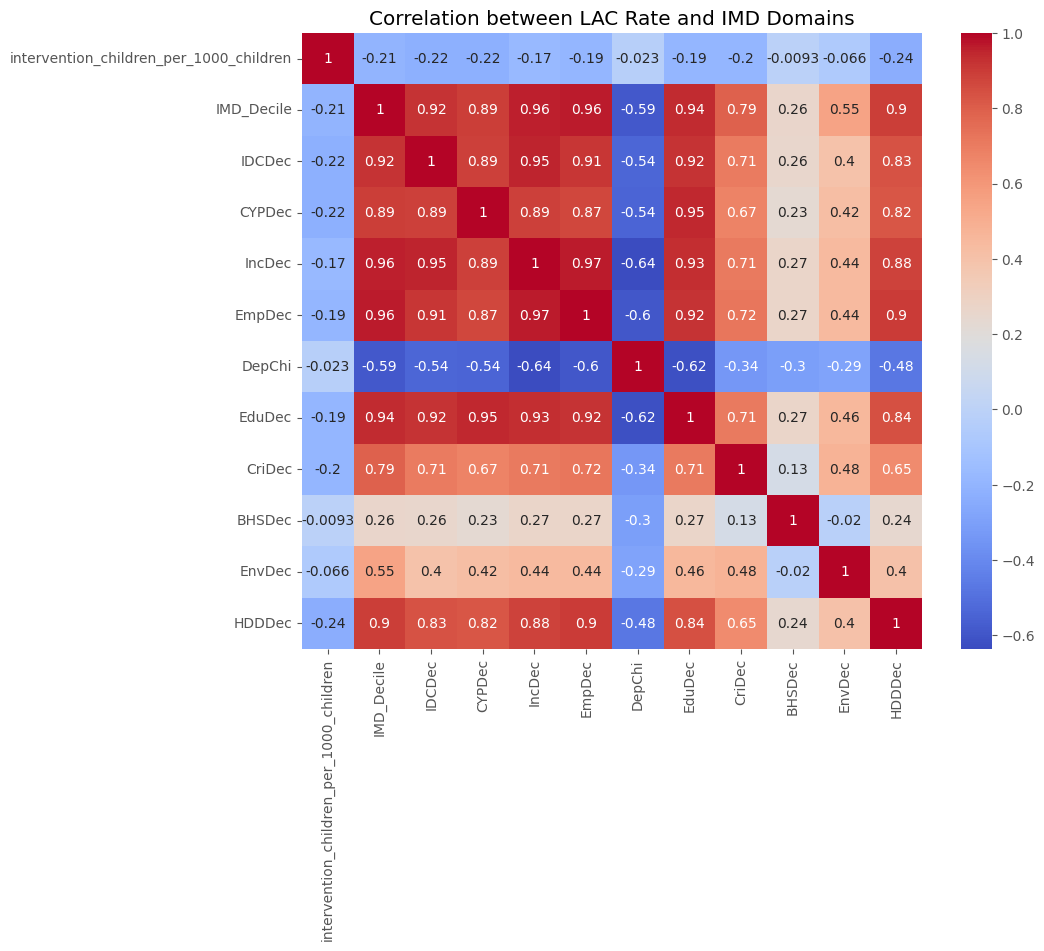

In [32]:
# Correlation Matric for IMD variables and lac rate per lsoa population
corr_matrix = clean_data[[
    'intervention_children_per_1000_children', 'IMD_Decile',
    'IDCDec', 'CYPDec', 'IncDec', 'EmpDec', 'DepChi',
    'EduDec', 'CriDec', 'BHSDec', 'EnvDec', 'HDDDec'
]].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between LAC Rate and IMD Domains')
plt.show()

### Correlation between LAC Population Rate and IMDs

In [33]:
import statsmodels.formula.api as smf

# 1. Define the formula for ordinary least squares (OLS) regression:
formula = "intervention_children_per_1000_children ~ DepChi + IncDec + EmpDec + EduDec + EnvDec + IDCDec + CriDec + HDDDec + CYPDec + BHSDec"

# 2. Fit the model
model = smf.ols(formula, data=children_population).fit()

# 3. Print a summary of the regression results
print(model.summary())

                                       OLS Regression Results                                      
Dep. Variable:     intervention_children_per_1000_children   R-squared:                       0.111
Model:                                                 OLS   Adj. R-squared:                  0.081
Method:                                      Least Squares   F-statistic:                     3.691
Date:                                     Thu, 20 Mar 2025   Prob (F-statistic):           0.000113
Time:                                             15:26:56   Log-Likelihood:                -992.73
No. Observations:                                      308   AIC:                             2007.
Df Residuals:                                          297   BIC:                             2048.
Df Model:                                               10                                         
Covariance Type:                                 nonrobust                                         


### Comparing Characteristics of children with intervention rates.
#### Characteristics of children in high rate areas vs Other areas

### Individual-Level

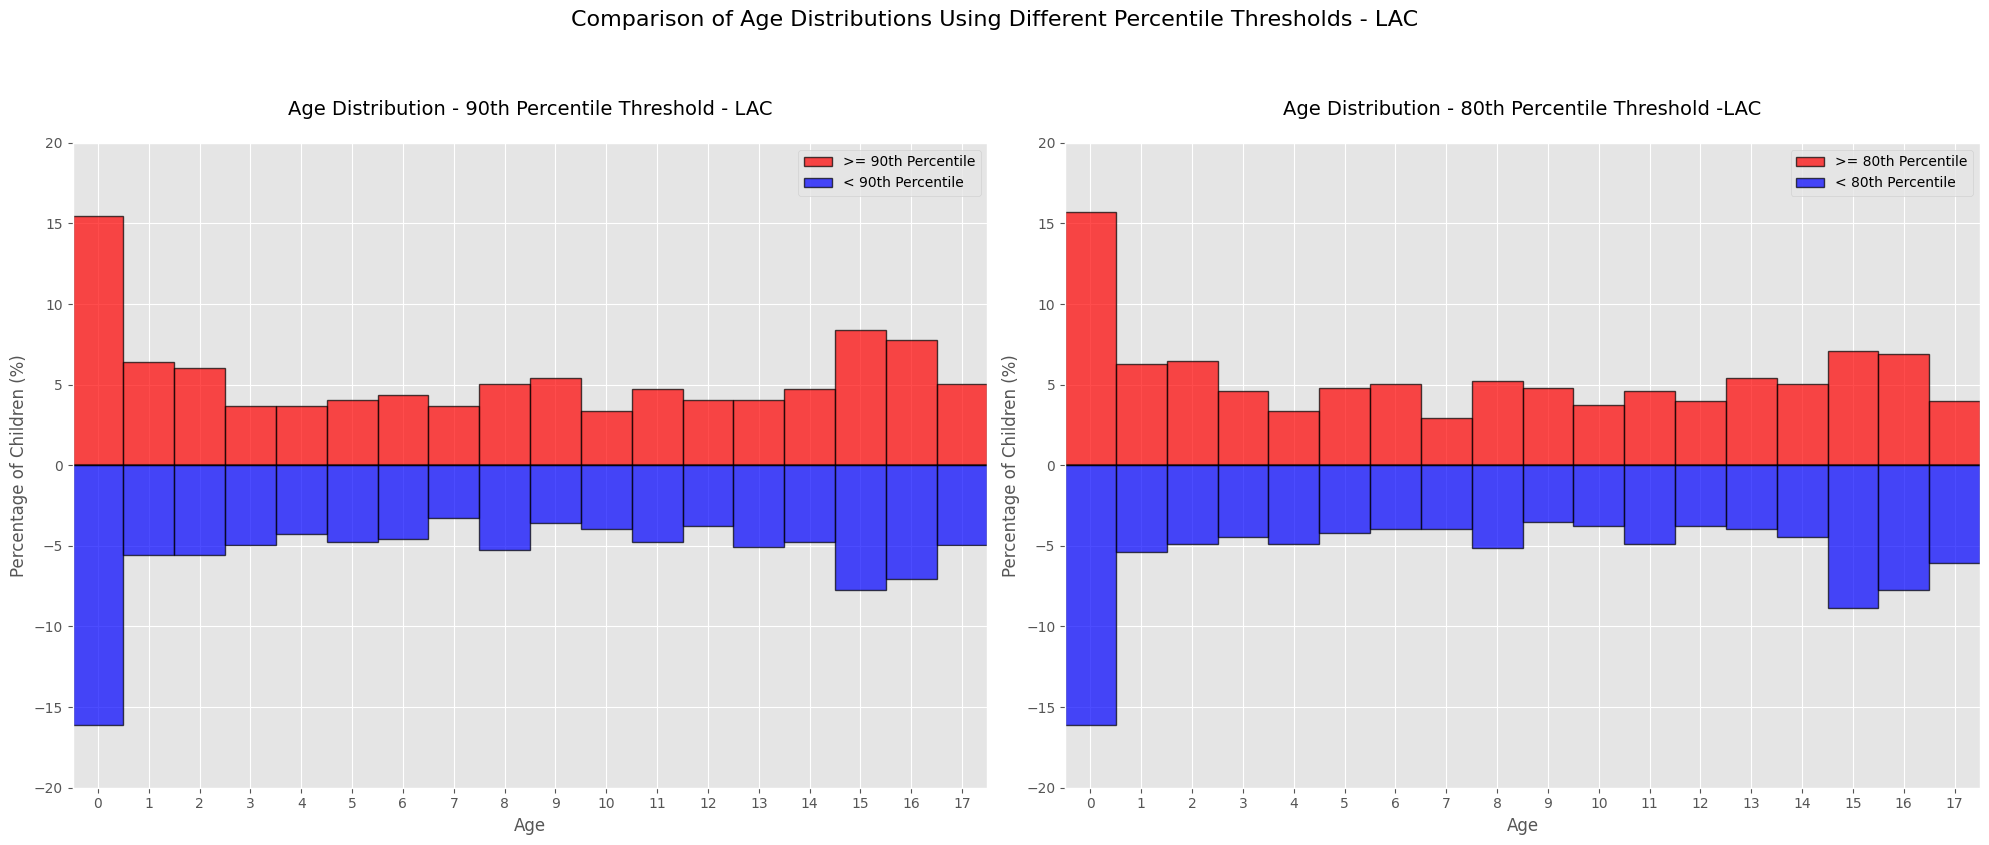

In [34]:
# Create a figure with two subplots side by side to compare 90th and 80th percentile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Define bin edges for ages 0-17
bins = np.arange(0, 19) - 0.5
x = np.arange(18)
width = 1.0  # Full width to ensure bars touch

# First subplot - 90th percentile
percentile_threshold_90 = 90
cutoff_value_90 = np.percentile(children_population['intervention_children_per_1000_children'], percentile_threshold_90)

# Select LSOAs above the 90th percentile threshold
high_intervention_lsoas_90 = children_population[children_population['intervention_children_per_1000_children'] >= cutoff_value_90]['lsoa21cd'].tolist()

# Split the data into high rate and other groups for 90th percentile
high_group_90 = merged_data[merged_data['lsoa21cd'].isin(high_intervention_lsoas_90)]
other_group_90 = merged_data[~merged_data['lsoa21cd'].isin(high_intervention_lsoas_90)]

# Calculate histograms using counts for 90th percentile
high_counts_90, _ = np.histogram(high_group_90['age_at_entry'], bins=bins)
other_counts_90, _ = np.histogram(other_group_90['age_at_entry'], bins=bins)

# Convert counts to percentages for 90th percentile
high_pct_90 = high_counts_90 / high_counts_90.sum() * 100
other_pct_90 = other_counts_90 / other_counts_90.sum() * 100

# Plot the 90th percentile histogram
ax1.bar(x, high_pct_90, width=width, align='center', color='red', alpha=0.7,
       edgecolor='black', linewidth=1.0,
       label='>= 90th Percentile')
ax1.bar(x, -other_pct_90, width=width, align='center', color='blue', alpha=0.7,
       edgecolor='black', linewidth=1.0,
       label='< 90th Percentile')

# -------------------------------------------------------------------------------------------------

# Second subplot - 80th percentile
percentile_threshold_80 = 80
cutoff_value_80 = np.percentile(children_population['intervention_children_per_1000_children'], percentile_threshold_80)

# Select LSOAs above the 80th percentile threshold
high_intervention_lsoas_80 = children_population[children_population['intervention_children_per_1000_children'] >= cutoff_value_80]['lsoa21cd'].tolist()

# Split the data into high rate and other groups for 80th percentile
high_group_80 = merged_data[merged_data['lsoa21cd'].isin(high_intervention_lsoas_80)]
other_group_80 = merged_data[~merged_data['lsoa21cd'].isin(high_intervention_lsoas_80)]

# Calculate histograms using counts for 80th percentile
high_counts_80, _ = np.histogram(high_group_80['age_at_entry'], bins=bins)
other_counts_80, _ = np.histogram(other_group_80['age_at_entry'], bins=bins)

# Convert counts to percentages for 80th percentile
high_pct_80 = high_counts_80 / high_counts_80.sum() * 100
other_pct_80 = other_counts_80 / other_counts_80.sum() * 100

# Plot the 80th percentile histogram
ax2.bar(x, high_pct_80, width=width, align='center', color='red', alpha=0.7,
       edgecolor='black', linewidth=1.0,
       label='>= 80th Percentile')
ax2.bar(x, -other_pct_80, width=width, align='center', color='blue', alpha=0.7,
       edgecolor='black', linewidth=1.0,
       label='< 80th Percentile')

# Format the first subplot (90th percentile)
ax1.set_ylabel('Percentage of Children (%)')
ax1.set_xlabel('Age')
ax1.set_title('Age Distribution - 90th Percentile Threshold - LAC', fontsize=14, pad=20)
ax1.set_xlim(-0.5, 17.5)
ax1.set_xticks(x)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax1.legend(loc='upper right')
ax1.set_ylim(-20, 20)

# Format the second subplot (80th percentile)
ax2.set_ylabel('Percentage of Children (%)')
ax2.set_xlabel('Age')
ax2.set_title('Age Distribution - 80th Percentile Threshold -LAC', fontsize=14, pad=20)
ax2.set_xlim(-0.5, 17.5)
ax2.set_xticks(x)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.legend(loc='upper right')
ax2.set_ylim(-20, 20)

# Add an overall title
fig.suptitle('Comparison of Age Distributions Using Different Percentile Thresholds - LAC', fontsize=16, y=1.05)

# Adjust layout
plt.tight_layout()
plt.savefig(f'../figs/LAC_agedist_high_other.png', dpi=300)
plt.show()

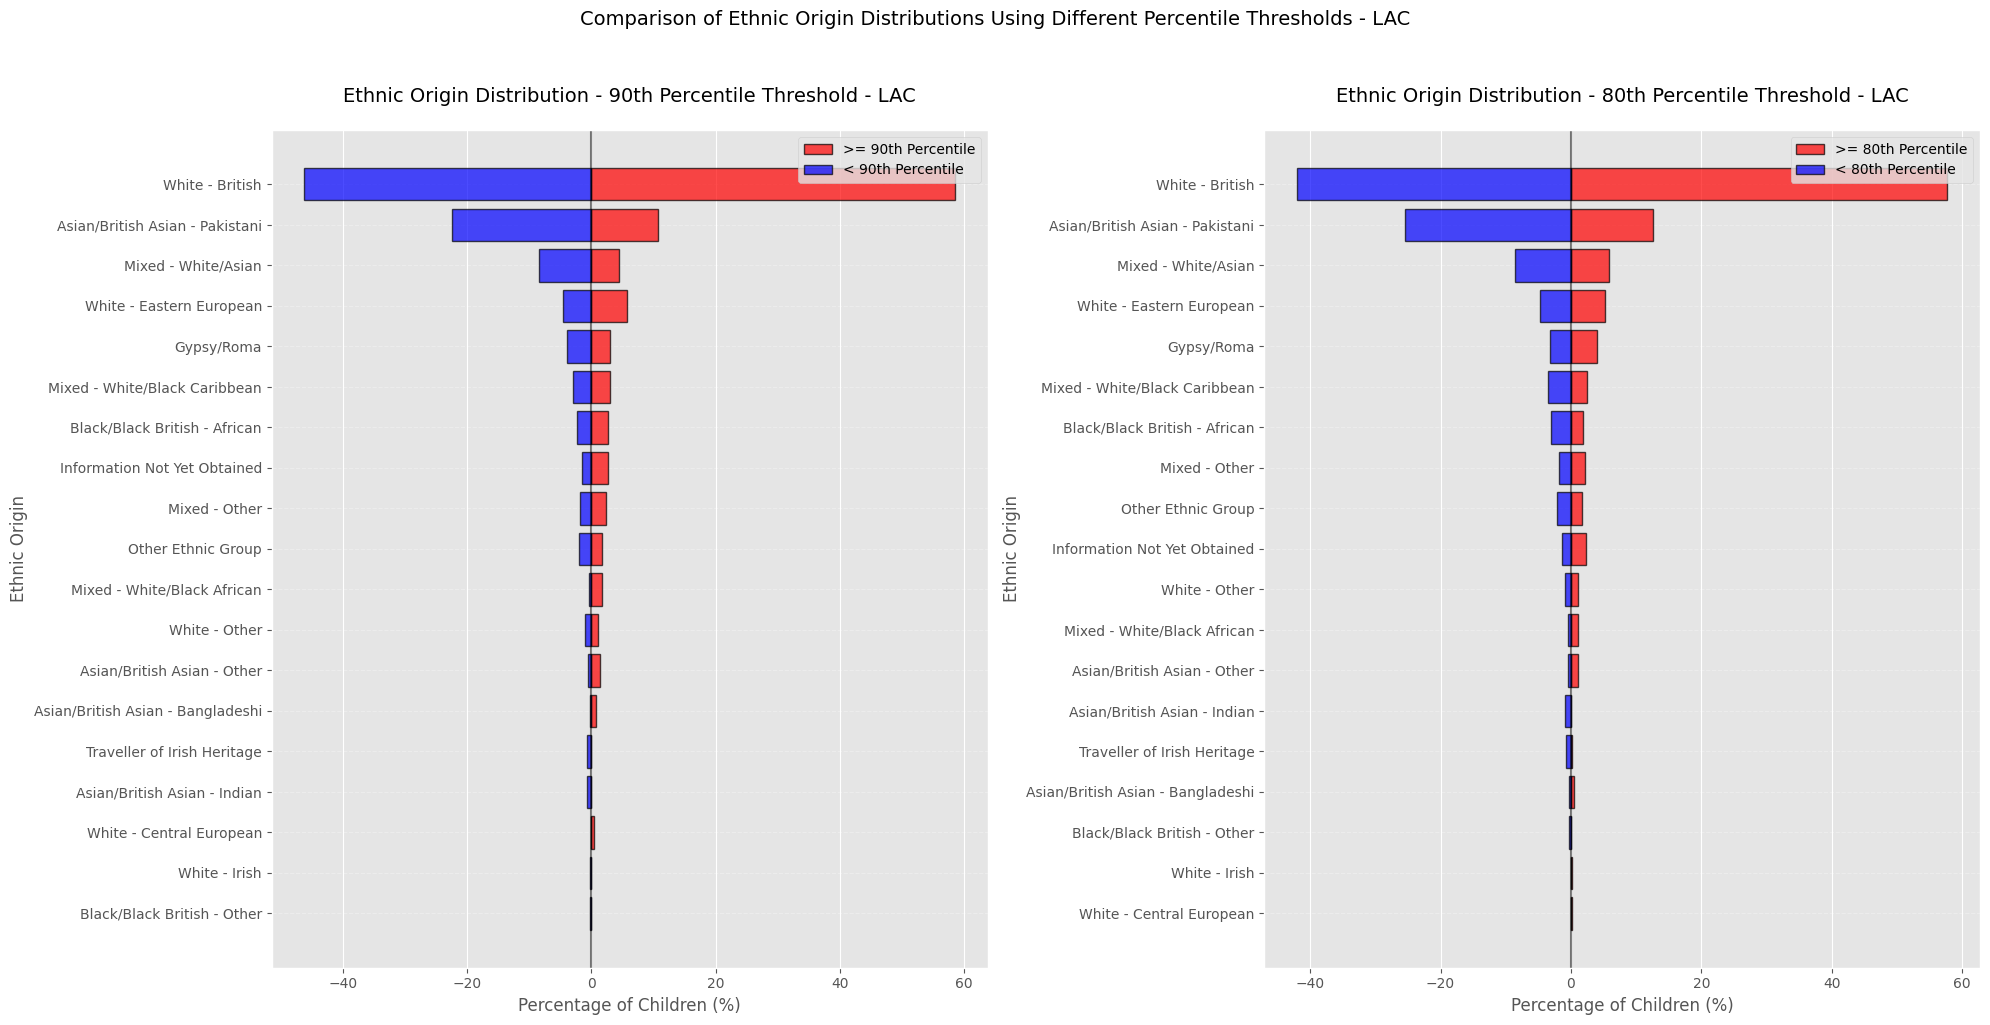

In [35]:
# Create a figure with two subplots side by side to compare 90th and 80th percentile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Define the percentile thresholds
percentile_threshold_90 = 90
percentile_threshold_80 = 80

# Calculate cutoff values
cutoff_value_90 = np.percentile(children_population['intervention_children_per_1000_children'], percentile_threshold_90)
cutoff_value_80 = np.percentile(children_population['intervention_children_per_1000_children'], percentile_threshold_80)

# Select LSOAs above the percentile thresholds
high_intervention_lsoas_90 = children_population[children_population['intervention_children_per_1000_children'] >= cutoff_value_90]['lsoa21cd'].tolist()
high_intervention_lsoas_80 = children_population[children_population['intervention_children_per_1000_children'] >= cutoff_value_80]['lsoa21cd'].tolist()

# Split the data into high rate and other groups for both percentiles
high_group_90 = merged_data[merged_data['lsoa21cd'].isin(high_intervention_lsoas_90)]
other_group_90 = merged_data[~merged_data['lsoa21cd'].isin(high_intervention_lsoas_90)]

high_group_80 = merged_data[merged_data['lsoa21cd'].isin(high_intervention_lsoas_80)]
other_group_80 = merged_data[~merged_data['lsoa21cd'].isin(high_intervention_lsoas_80)]

# Process for 90th percentile (left subplot)
# Get the counts for each ethnic origin category
high_ethnicity_counts_90 = high_group_90['EthnicOrigin'].value_counts()
other_ethnicity_counts_90 = other_group_90['EthnicOrigin'].value_counts()

# Convert to percentages
high_ethnicity_pct_90 = high_ethnicity_counts_90 / high_ethnicity_counts_90.sum() * 100
other_ethnicity_pct_90 = other_ethnicity_counts_90 / other_ethnicity_counts_90.sum() * 100

# Combine the categories to ensure both groups have the same categories
all_categories_90 = sorted(set(high_ethnicity_pct_90.index) | set(other_ethnicity_pct_90.index))

# Reindex to include all categories, filling missing values with 0
high_ethnicity_pct_90 = high_ethnicity_pct_90.reindex(all_categories_90, fill_value=0)
other_ethnicity_pct_90 = other_ethnicity_pct_90.reindex(all_categories_90, fill_value=0)

# Sort categories by total percentage (high + other) in descending order
total_pct_90 = high_ethnicity_pct_90 + other_ethnicity_pct_90
sorted_categories_90 = total_pct_90.sort_values(ascending=True).index  # Ascending for bottom-to-top

# Reindex according to sorted order
high_ethnicity_pct_90 = high_ethnicity_pct_90.reindex(sorted_categories_90)
other_ethnicity_pct_90 = other_ethnicity_pct_90.reindex(sorted_categories_90)

# Process for 80th percentile (right subplot)
# Get the counts for each ethnic origin category
high_ethnicity_counts_80 = high_group_80['EthnicOrigin'].value_counts()
other_ethnicity_counts_80 = other_group_80['EthnicOrigin'].value_counts()

# Convert to percentages
high_ethnicity_pct_80 = high_ethnicity_counts_80 / high_ethnicity_counts_80.sum() * 100
other_ethnicity_pct_80 = other_ethnicity_counts_80 / other_ethnicity_counts_80.sum() * 100

# Combine the categories to ensure both groups have the same categories
all_categories_80 = sorted(set(high_ethnicity_pct_80.index) | set(other_ethnicity_pct_80.index))

# Reindex to include all categories, filling missing values with 0
high_ethnicity_pct_80 = high_ethnicity_pct_80.reindex(all_categories_80, fill_value=0)
other_ethnicity_pct_80 = other_ethnicity_pct_80.reindex(all_categories_80, fill_value=0)

# Sort categories by total percentage (high + other) in descending order
total_pct_80 = high_ethnicity_pct_80 + other_ethnicity_pct_80
sorted_categories_80 = total_pct_80.sort_values(ascending=True).index  # Ascending for bottom-to-top

# Reindex according to sorted order
high_ethnicity_pct_80 = high_ethnicity_pct_80.reindex(sorted_categories_80)
other_ethnicity_pct_80 = other_ethnicity_pct_80.reindex(sorted_categories_80)

# Create horizontal bars for 90th percentile (left subplot)
y_pos_90 = np.arange(len(sorted_categories_90))
width = 0.8  # Bar width

ax1.barh(y_pos_90, high_ethnicity_pct_90, height=width, color='red', alpha=0.7,
         edgecolor='black', linewidth=1.0, label='>= 90th Percentile')
ax1.barh(y_pos_90, -other_ethnicity_pct_90, height=width, color='blue', alpha=0.7,
         edgecolor='black', linewidth=1.0, label='< 90th Percentile')

# Create horizontal bars for 80th percentile (right subplot)
y_pos_80 = np.arange(len(sorted_categories_80))

ax2.barh(y_pos_80, high_ethnicity_pct_80, height=width, color='red', alpha=0.7,
         edgecolor='black', linewidth=1.0, label='>= 80th Percentile')
ax2.barh(y_pos_80, -other_ethnicity_pct_80, height=width, color='blue', alpha=0.7,
         edgecolor='black', linewidth=1.0, label='< 80th Percentile')

# Format the first subplot (90th percentile)
ax1.set_xlabel('Percentage of Children (%)')
ax1.set_ylabel('Ethnic Origin')
ax1.set_title('Ethnic Origin Distribution - 90th Percentile Threshold - LAC', fontsize=14, pad=20)
ax1.set_yticks(y_pos_90)
ax1.set_yticklabels(sorted_categories_90)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax1.grid(axis='y', linestyle='--', alpha=0.3)
ax1.legend(loc='upper right')

# Format the second subplot (80th percentile)
ax2.set_xlabel('Percentage of Children (%)')
ax2.set_ylabel('Ethnic Origin')
ax2.set_title('Ethnic Origin Distribution - 80th Percentile Threshold - LAC', fontsize=14, pad=20)
ax2.set_yticks(y_pos_80)
ax2.set_yticklabels(sorted_categories_80)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax2.grid(axis='y', linestyle='--', alpha=0.3)
ax2.legend(loc='upper right')

# Add an overall title
fig.suptitle('Comparison of Ethnic Origin Distributions Using Different Percentile Thresholds - LAC', fontsize=14, y=1.02)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f'../figs/LAC_ethnicity_dist_high_other.png', dpi=300)
plt.show()

### Keep top two ethnicities and group the rest as "Others"

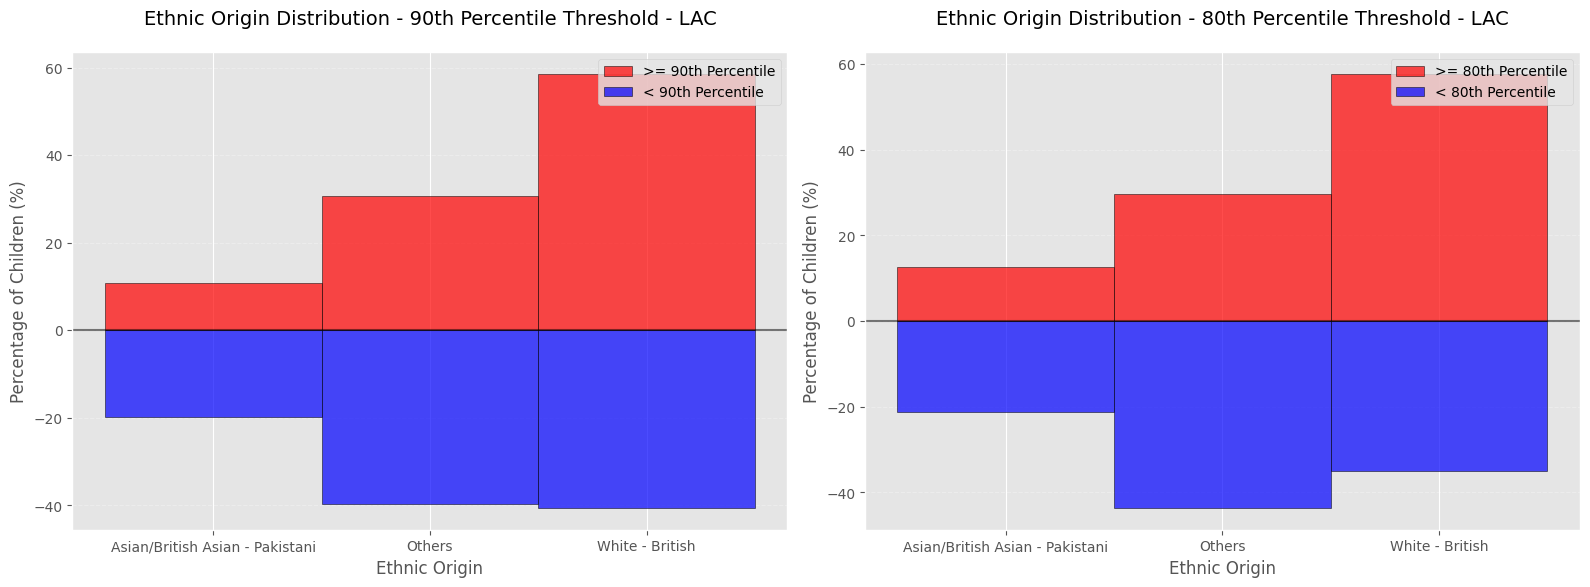

In [36]:
# Create a figure with two subplots side by side to compare 90th and 80th percentile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Group ethnicities - keep top 2 and group others
# Get the counts for the entire dataset to determine top categories
ethnicity_counts = merged_data['EthnicOrigin'].value_counts()
top_categories = ethnicity_counts.nlargest(2).index.tolist()

# Create a mapping function
def map_ethnicity(x):
    return x if x in top_categories else 'Others'

# Apply grouping to each dataset
high_group_90['EthnicOrigin_grouped'] = high_group_90['EthnicOrigin'].apply(map_ethnicity)
other_group_90['EthnicOrigin_grouped'] = other_group_90['EthnicOrigin'].apply(map_ethnicity)
high_group_80['EthnicOrigin_grouped'] = high_group_80['EthnicOrigin'].apply(map_ethnicity)
other_group_80['EthnicOrigin_grouped'] = other_group_80['EthnicOrigin'].apply(map_ethnicity)

# Process for 90th percentile (left subplot)
high_ethnicity_counts_90 = high_group_90['EthnicOrigin_grouped'].value_counts()
other_ethnicity_counts_90 = other_group_90['EthnicOrigin_grouped'].value_counts()

# Convert to percentages
high_ethnicity_pct_90 = high_ethnicity_counts_90 / high_ethnicity_counts_90.sum() * 100
other_ethnicity_pct_90 = other_ethnicity_counts_90 / other_ethnicity_counts_90.sum() * 100

# Combine the categories to ensure both groups have the same categories
all_categories_90 = sorted(set(high_ethnicity_pct_90.index) | set(other_ethnicity_pct_90.index))

# Reindex to include all categories, filling missing values with 0
high_ethnicity_pct_90 = high_ethnicity_pct_90.reindex(all_categories_90, fill_value=0)
other_ethnicity_pct_90 = other_ethnicity_pct_90.reindex(all_categories_90, fill_value=0)

# Process for 80th percentile (right subplot)
high_ethnicity_counts_80 = high_group_80['EthnicOrigin_grouped'].value_counts()
other_ethnicity_counts_80 = other_group_80['EthnicOrigin_grouped'].value_counts()

# Convert to percentages
high_ethnicity_pct_80 = high_ethnicity_counts_80 / high_ethnicity_counts_80.sum() * 100
other_ethnicity_pct_80 = other_ethnicity_counts_80 / other_ethnicity_counts_80.sum() * 100

# Combine the categories to ensure both groups have the same categories
all_categories_80 = sorted(set(high_ethnicity_pct_80.index) | set(other_ethnicity_pct_80.index))

# Reindex to include all categories, filling missing values with 0
high_ethnicity_pct_80 = high_ethnicity_pct_80.reindex(all_categories_80, fill_value=0)
other_ethnicity_pct_80 = other_ethnicity_pct_80.reindex(all_categories_80, fill_value=0)

# Create vertical mirrored bar plots
# 90th percentile (left subplot)
x_pos_90 = np.arange(len(all_categories_90))
width = 1.0  # Width of bars

# Create mirrored bar chart for 90th percentile
ax1.bar(x_pos_90, high_ethnicity_pct_90, width=width, color='red', alpha=0.7,
        edgecolor='black', linewidth=0.5, label='>= 90th Percentile')
ax1.bar(x_pos_90, -other_ethnicity_pct_90, width=width, color='blue', alpha=0.7,
        edgecolor='black', linewidth=0.5, label='< 90th Percentile')

# 80th percentile (right subplot)
x_pos_80 = np.arange(len(all_categories_80))

# Create mirrored bar chart for 80th percentile
ax2.bar(x_pos_80, high_ethnicity_pct_80, width, color='red', alpha=0.7,
        edgecolor='black', linewidth=0.5, label='>= 80th Percentile')
ax2.bar(x_pos_80, -other_ethnicity_pct_80, width, color='blue', alpha=0.7,
        edgecolor='black', linewidth=0.5, label='< 80th Percentile')

# Format the first subplot (90th percentile)
ax1.set_ylabel('Percentage of Children (%)')
ax1.set_xlabel('Ethnic Origin')
ax1.set_title('Ethnic Origin Distribution - 90th Percentile Threshold - LAC', fontsize=14, pad=20)
ax1.set_xticks(x_pos_90)
ax1.set_xticklabels(all_categories_90, rotation=0)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax1.grid(axis='y', linestyle='--', alpha=0.3)
ax1.legend(loc='upper right')

# Format the second subplot (80th percentile)
ax2.set_ylabel('Percentage of Children (%)')
ax2.set_xlabel('Ethnic Origin')
ax2.set_title('Ethnic Origin Distribution - 80th Percentile Threshold - LAC', fontsize=14, pad=20)
ax2.set_xticks(x_pos_80)
ax2.set_xticklabels(all_categories_80, rotation=0)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.grid(axis='y', linestyle='--', alpha=0.3)
ax2.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f'../figs/LAC_ethnicity_dist_high_other_grouped.png', dpi=300)
plt.show()

### Area Level

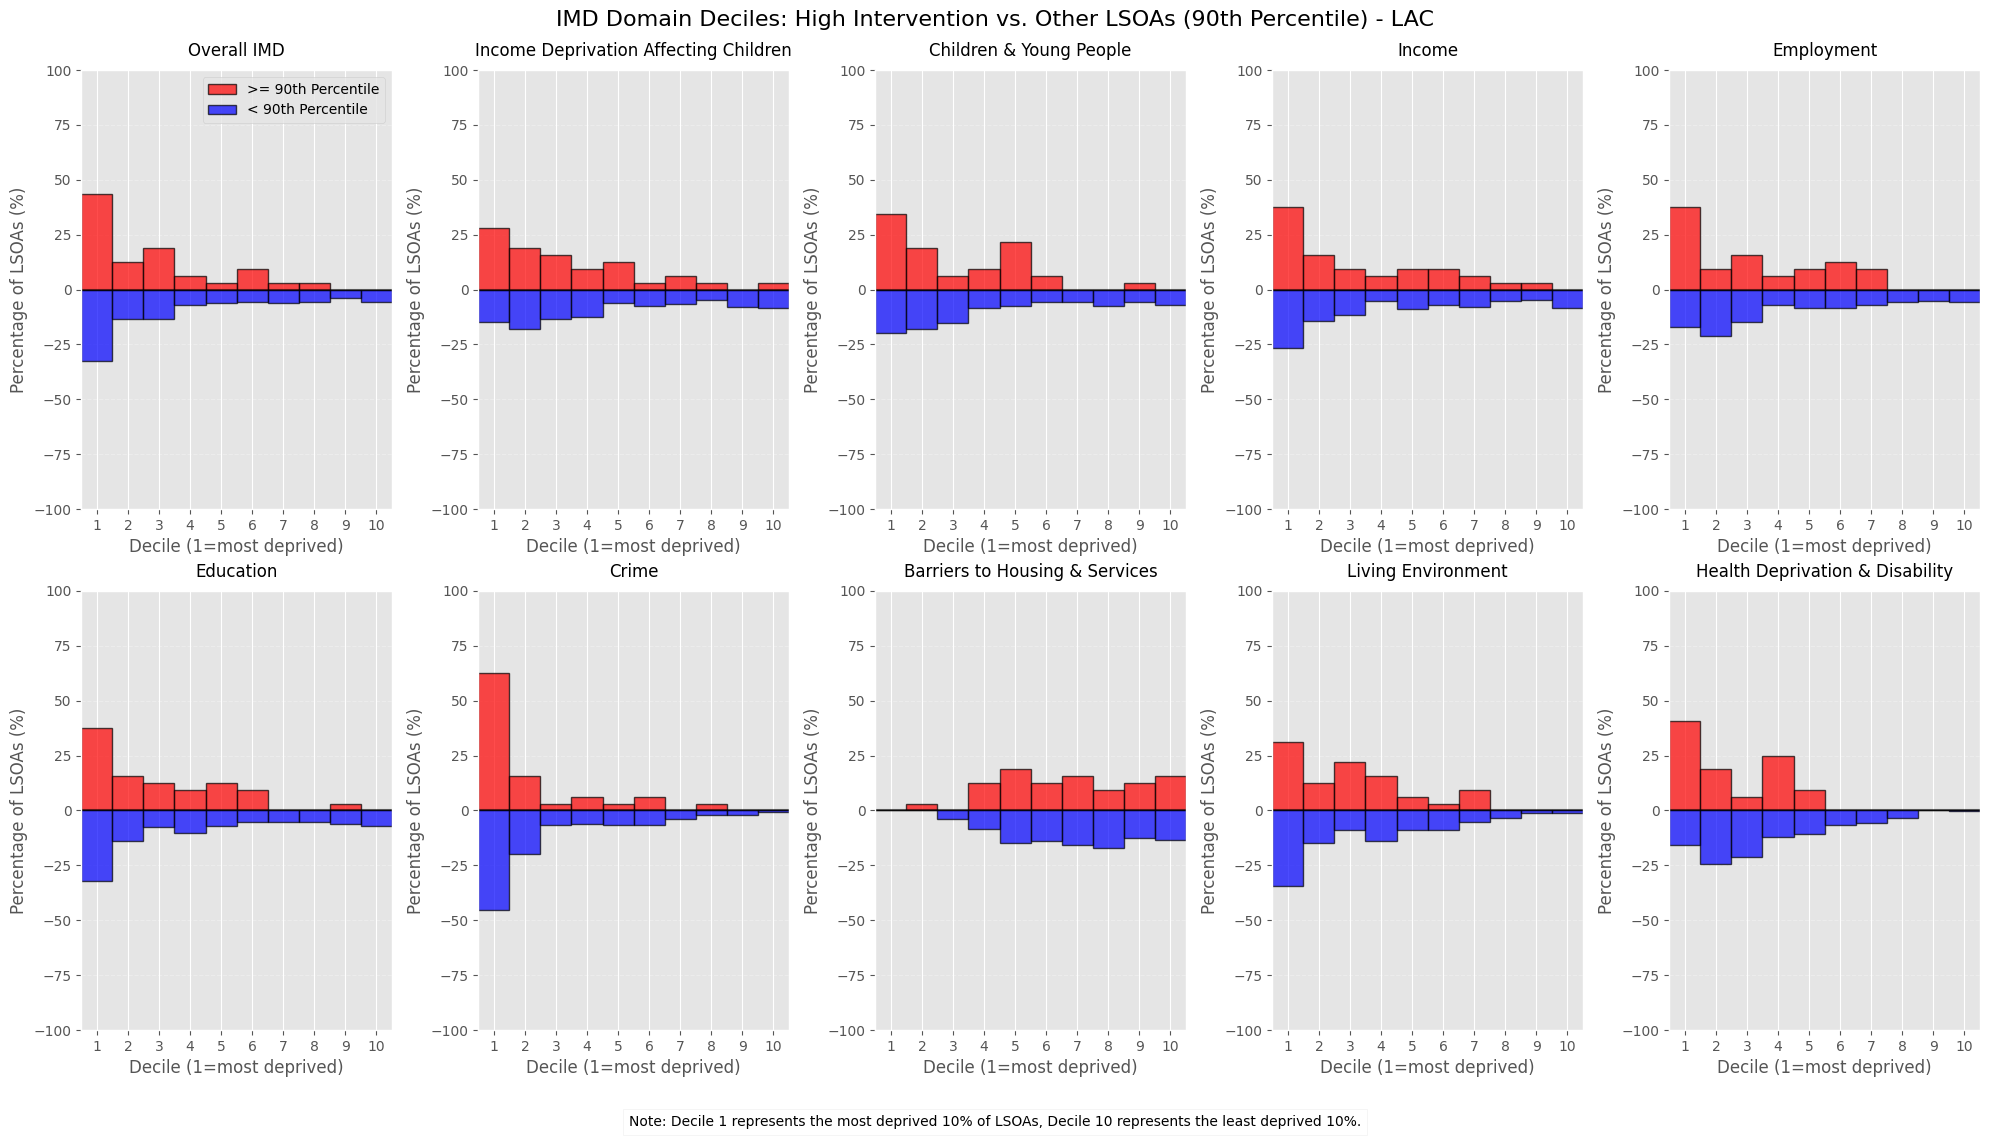

In [37]:
# First, calculate the intervention rate threshold for the 90th percentile
percentile_threshold = 90
cutoff_value = np.percentile(children_population['intervention_children_per_1000_children'], percentile_threshold)

# Identify high-intervention LSOAs
children_population['high_intervention'] = children_population['intervention_children_per_1000_children'] >= cutoff_value

# Split into high and other groups
high_lsoa_group = children_population[children_population['high_intervention']]
other_lsoa_group = children_population[~children_population['high_intervention']]

# List of IMD domains to analyze (using the deciles)
imd_domains = ['IMD_Decile', 'IDCDec', 'CYPDec', 'IncDec', 'EmpDec',
               'EduDec', 'CriDec', 'BHSDec', 'EnvDec', 'HDDDec']

# Create a dictionary to map domain codes to more readable names
domain_names = {
    'IMD_Decile': 'Overall IMD',
    'IDCDec': 'Income Deprivation Affecting Children',
    'CYPDec': 'Children & Young People',
    'IncDec': 'Income',
    'EmpDec': 'Employment',
    'EduDec': 'Education',
    'CriDec': 'Crime',
    'BHSDec': 'Barriers to Housing & Services',
    'EnvDec': 'Living Environment',
    'HDDDec': 'Health Deprivation & Disability'
}

# Create a figure with multiple subplots - one for each domain
fig, axes = plt.subplots(2, 5, figsize=(20, 12))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten to make indexing easier
fig.suptitle('IMD Domain Deciles: High Intervention vs. Other LSOAs (90th Percentile) - LAC',
             fontsize=16, y=0.95)

# For each domain, create a vertical mirrored histogram
for i, domain in enumerate(imd_domains):
    ax = axes[i]

    # Calculate the distribution of deciles for high and other LSOAs
    high_counts = high_lsoa_group[domain].value_counts().sort_index()
    other_counts = other_lsoa_group[domain].value_counts().sort_index()

    # Convert to percentages
    high_pct = high_counts / high_counts.sum() * 100
    other_pct = other_counts / other_counts.sum() * 100

    # Ensure all deciles (1-10) are represented
    all_deciles = range(1, 11)
    high_pct = high_pct.reindex(all_deciles, fill_value=0)
    other_pct = other_pct.reindex(all_deciles, fill_value=0)

    # Create vertical bars with width=1.0 to ensure they touch
    x_pos = np.arange(0.5, 10.5)  # Position bars at 0.5, 1.5, ..., 9.5
    width = 1.0  # Full width to ensure bars touch

    # Plot vertical bars
    ax.bar(x_pos, high_pct, width=width, color='red', alpha=0.7,
           edgecolor='black', linewidth=1.0, label='>= 90th Percentile', align='center')
    ax.bar(x_pos, -other_pct, width=width, color='blue', alpha=0.7,
           edgecolor='black', linewidth=1.0, label='< 90th Percentile', align='center')

    # Add labels and formatting
    ax.set_ylabel('Percentage of LSOAs (%)')
    ax.set_xlabel('Decile (1=most deprived)')
    ax.set_title(f'{domain_names[domain]}', fontsize=12, pad=10)

    # Set x-ticks at the center of each bar
    ax.set_xticks(x_pos)
    ax.set_xticklabels(range(1, 11))

    # Set x-limits to ensure bars are fully visible
    ax.set_xlim(0, 10)

    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Set y-axis limits to be symmetric
    y_max = max(high_pct.max(), other_pct.max()) * 1.1
    ax.set_ylim(-100, 100)

    # Add legend only to the first subplot
    if i == 0:
        ax.legend(loc='upper right')

# Add note about deciles
fig.text(0.5, 0.02,
         'Note: Decile 1 represents the most deprived 10% of LSOAs, Decile 10 represents the least deprived 10%.',
         ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.savefig(f'../figs/LAC_IMDs_dist_high_other_groups_90th.png', dpi=300)
plt.show()

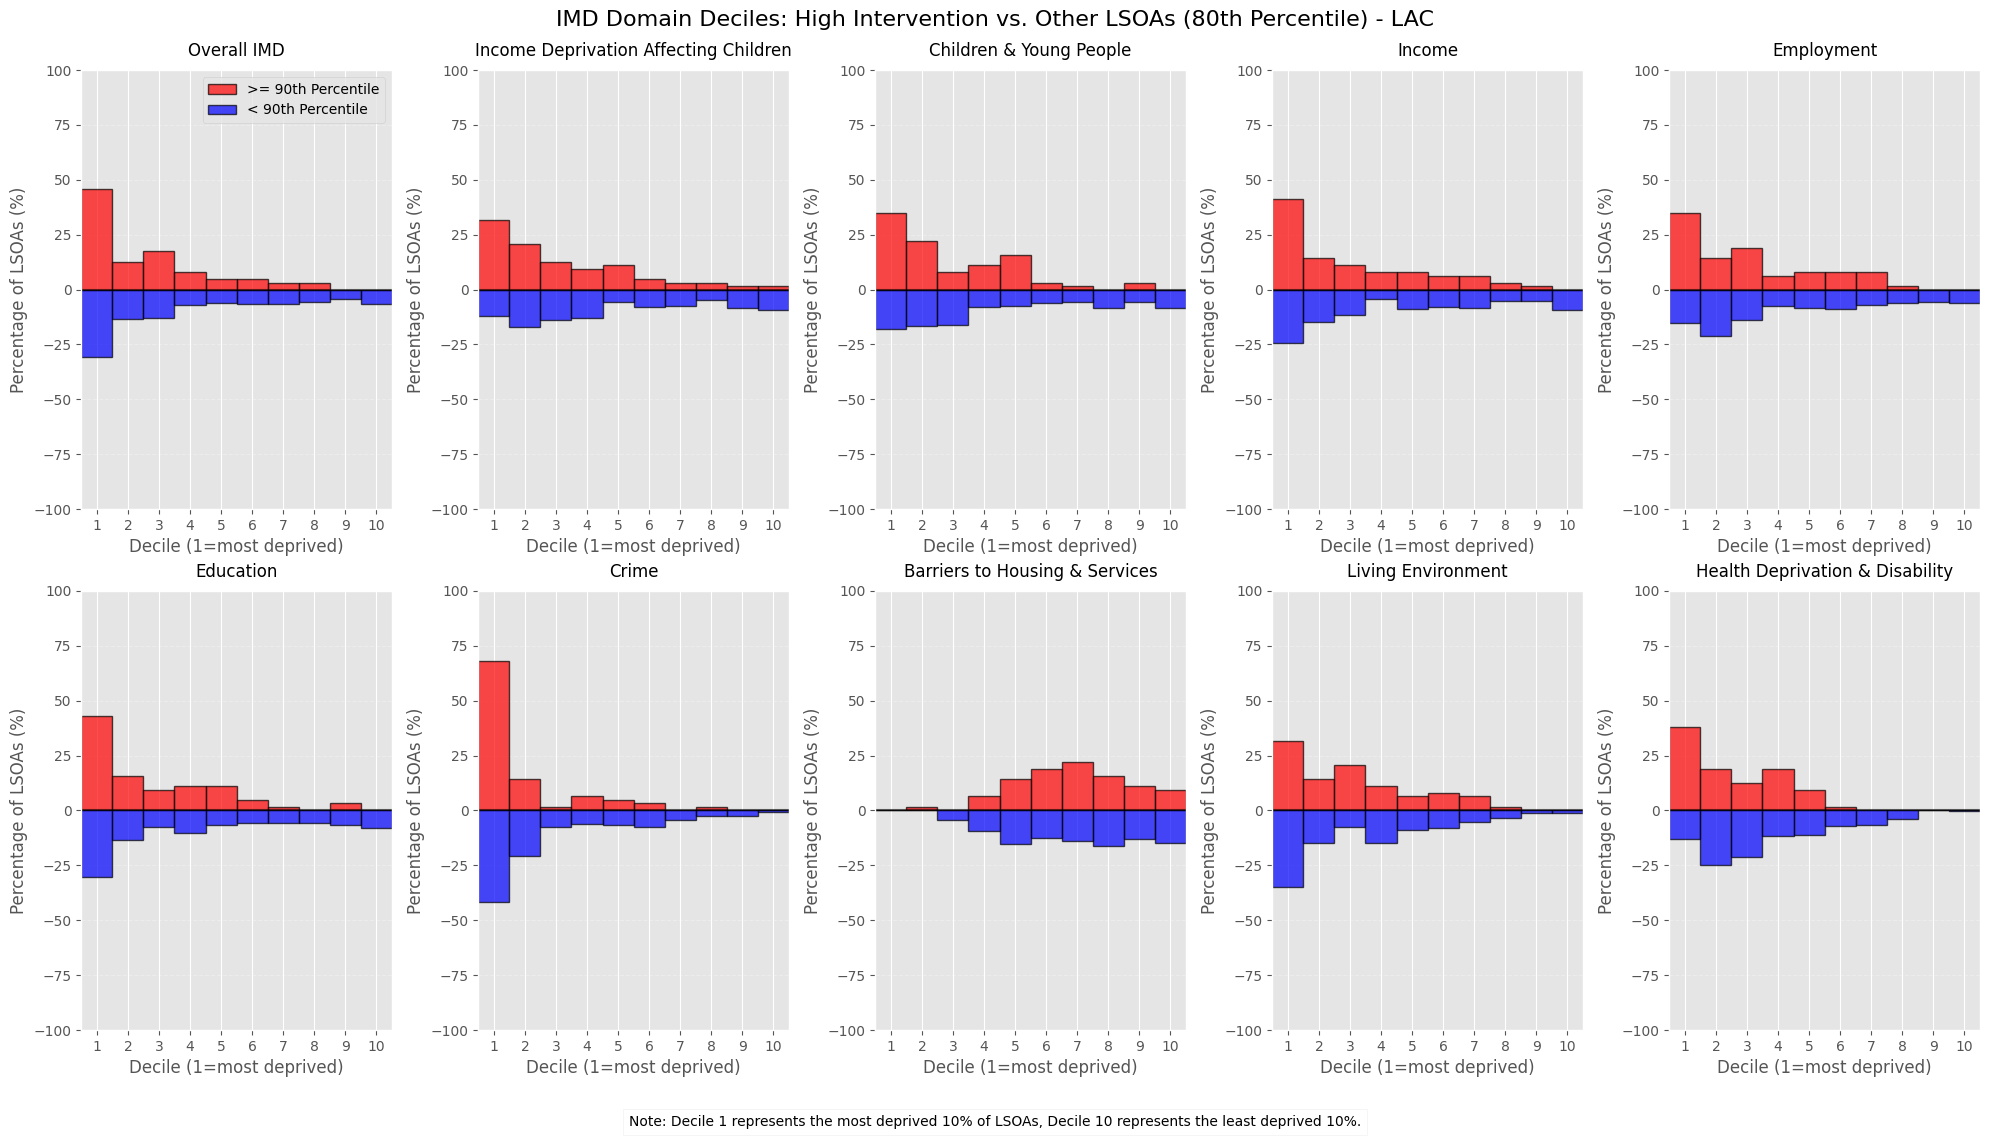

In [38]:
# First, calculate the intervention rate threshold for the 90th percentile
percentile_threshold = 80
cutoff_value_80 = np.percentile(children_population['intervention_children_per_1000_children'], percentile_threshold)

# Identify high-intervention LSOAs
children_population['high_intervention'] = children_population['intervention_children_per_1000_children'] >= cutoff_value_80

# Split into high and other groups
high_lsoa_group = children_population[children_population['high_intervention']]
other_lsoa_group = children_population[~children_population['high_intervention']]

# Create a figure with multiple subplots - one for each domain
fig, axes = plt.subplots(2, 5, figsize=(20, 12))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten to make indexing easier
fig.suptitle('IMD Domain Deciles: High Intervention vs. Other LSOAs (80th Percentile) - LAC',
             fontsize=16, y=0.95)

# For each domain, create a vertical mirrored histogram
for i, domain in enumerate(imd_domains):
    ax = axes[i]

    # Calculate the distribution of deciles for high and other LSOAs
    high_counts = high_lsoa_group[domain].value_counts().sort_index()
    other_counts = other_lsoa_group[domain].value_counts().sort_index()

    # Convert to percentages
    high_pct = high_counts / high_counts.sum() * 100
    other_pct = other_counts / other_counts.sum() * 100

    # Ensure all deciles (1-10) are represented
    all_deciles = range(1, 11)
    high_pct = high_pct.reindex(all_deciles, fill_value=0)
    other_pct = other_pct.reindex(all_deciles, fill_value=0)

    # Create vertical bars
    x_pos = np.arange(0.5, 10.5)  
    width = 1.0  

    # Plot vertical bars
    ax.bar(x_pos, high_pct, width=width, color='red', alpha=0.7,
           edgecolor='black', linewidth=1.0, label='>= 90th Percentile', align='center')
    ax.bar(x_pos, -other_pct, width=width, color='blue', alpha=0.7,
           edgecolor='black', linewidth=1.0, label='< 90th Percentile', align='center')

    # Add labels and formatting
    ax.set_ylabel('Percentage of LSOAs (%)')
    ax.set_xlabel('Decile (1=most deprived)')
    ax.set_title(f'{domain_names[domain]}', fontsize=12, pad=10)

    # Set x-ticks at the center of each bar
    ax.set_xticks(x_pos)
    ax.set_xticklabels(range(1, 11))

    # Set x-limits to ensure bars are fully visible
    ax.set_xlim(0, 10)

    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Set y-axis limits to be symmetric
    y_max = max(high_pct.max(), other_pct.max()) * 1.1
    ax.set_ylim(-100, 100)

    # Add legend only to the first subplot
    if i == 0:
        ax.legend(loc='upper right')

# Add note about deciles
fig.text(0.5, 0.02,
         'Note: Decile 1 represents the most deprived 10% of LSOAs, Decile 10 represents the least deprived 10%.',
         ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.savefig(f'../figs/LAC_IMDs_dist_high_other_groups_80th.png', dpi=300)
plt.show()